In [1]:
import torch

print(torch.__version__)
print("GPU 사용:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.5.0+cu121
GPU 사용: True


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline


def make_generator_network(
        input_size=20,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())
        input_size = num_hidden_units
    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())
    return model


def make_discriminator_network(
        input_size,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False))
        model.add_module(f'relu_d{i}', nn.LeakyReLU())
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())
    return model

In [4]:
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [5]:
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [6]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

example, label = next(iter(mnist_dataset))
print(f'최소: {example.min()} 최대: {example.max()}')
print(example.shape)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:10<00:00, 911kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.63MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

최소: -1.0 최대: 1.0
torch.Size([1, 28, 28])


In [7]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [8]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

torch.manual_seed(1)
mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)

print('input-z -- 크기:', input_z.shape)
print('input-real -- 크기:', input_real.shape)

g_output = gen_model(input_z)
print('생성자 출력 -- 크기:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('판별자 (진짜) -- 크기:', d_proba_real.shape)
print('판별자 (가짜) -- 크기:', d_proba_fake.shape)

input-z -- 크기: torch.Size([32, 20])
input-real -- 크기: torch.Size([32, 784])
생성자 출력 -- 크기: torch.Size([32, 784])
판별자 (진짜) -- 크기: torch.Size([32, 1])
판별자 (가짜) -- 크기: torch.Size([32, 1])


In [9]:
loss_fn = nn.BCELoss()

g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'판별자 손실: 진짜 {d_loss_real:.4f} 가짜 {d_loss_fake:.4f}')

Generator Loss: 0.6983
판별자 손실: 진짜 0.7479 가짜 0.6885


In [10]:
batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)).to(device)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [11]:
def d_train(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [12]:
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [13]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)


def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images + 1) / 2.0


epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs + 1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'에포크 {epoch:03d} | 평균 손실 >>'
          f' 생성자/판별자 {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [판별자-진짜: {all_d_real[-1]:.4f} 판별자-가짜: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 평균 손실 >> 생성자/판별자 0.9065/0.8923 [판별자-진짜: 0.8087 판별자-가짜: 0.4672]
에포크 002 | 평균 손실 >> 생성자/판별자 0.9354/1.1387 [판별자-진짜: 0.6082 판별자-가짜: 0.4260]
에포크 003 | 평균 손실 >> 생성자/판별자 1.1056/1.0995 [판별자-진짜: 0.6279 판별자-가짜: 0.4023]
에포크 004 | 평균 손실 >> 생성자/판별자 0.9267/1.2065 [판별자-진짜: 0.5775 판별자-가짜: 0.4242]
에포크 005 | 평균 손실 >> 생성자/판별자 1.0290/1.1769 [판별자-진짜: 0.5885 판별자-가짜: 0.4123]
에포크 006 | 평균 손실 >> 생성자/판별자 1.0491/1.1745 [판별자-진짜: 0.5931 판별자-가짜: 0.4063]
에포크 007 | 평균 손실 >> 생성자/판별자 1.0393/1.1553 [판별자-진짜: 0.6022 판별자-가짜: 0.4019]
에포크 008 | 평균 손실 >> 생성자/판별자 0.9979/1.1944 [판별자-진짜: 0.5827 판별자-가짜: 0.4128]
에포크 009 | 평균 손실 >> 생성자/판별자 1.0180/1.1693 [판별자-진짜: 0.5974 판별자-가짜: 0.4046]
에포크 010 | 평균 손실 >> 생성자/판별자 0.9745/1.1905 [판별자-진짜: 0.5872 판별자-가짜: 0.4133]
에포크 011 | 평균 손실 >> 생성자/판별자 1.0125/1.1836 [판별자-진짜: 0.5936 판별자-가짜: 0.4083]
에포크 012 | 평균 손실 >> 생성자/판별자 0.9935/1.1842 [판별자-진짜: 0.5915 판별자-가짜: 0.4107]
에포크 013 | 평균 손실 >> 생성자/판별자 0.8894/1.2595 [판별자-진짜: 0.5596 판별자-가짜: 0.4387]
에포크 014 | 평균 손실 >> 생성자/판별자 0.8784/1.2628 [판별자-진짜: 0

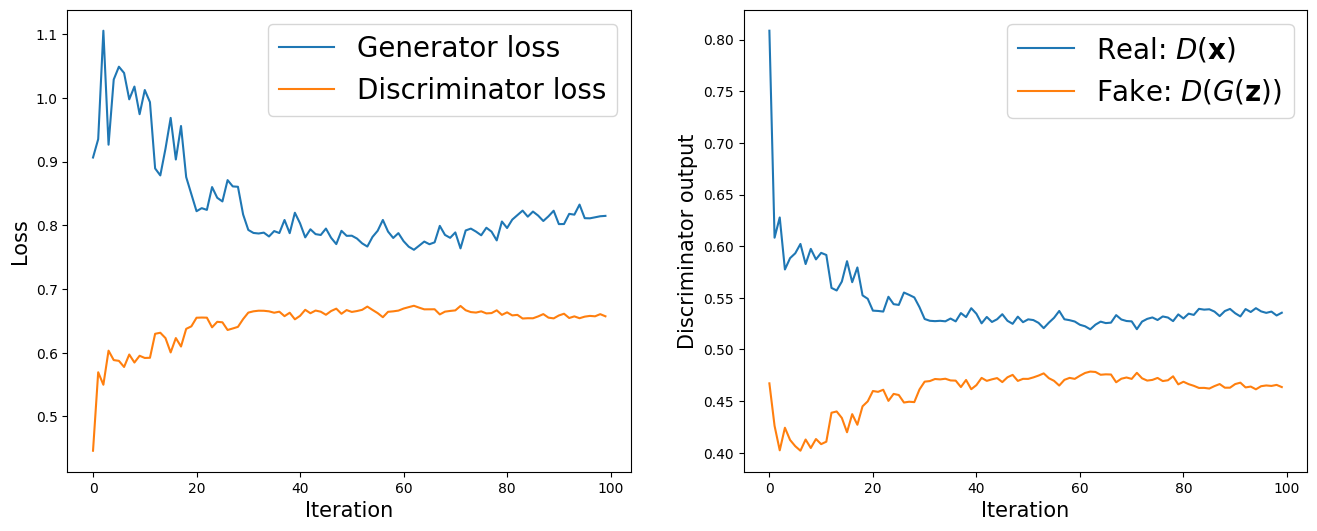

In [14]:
import itertools

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)

plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss / 2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

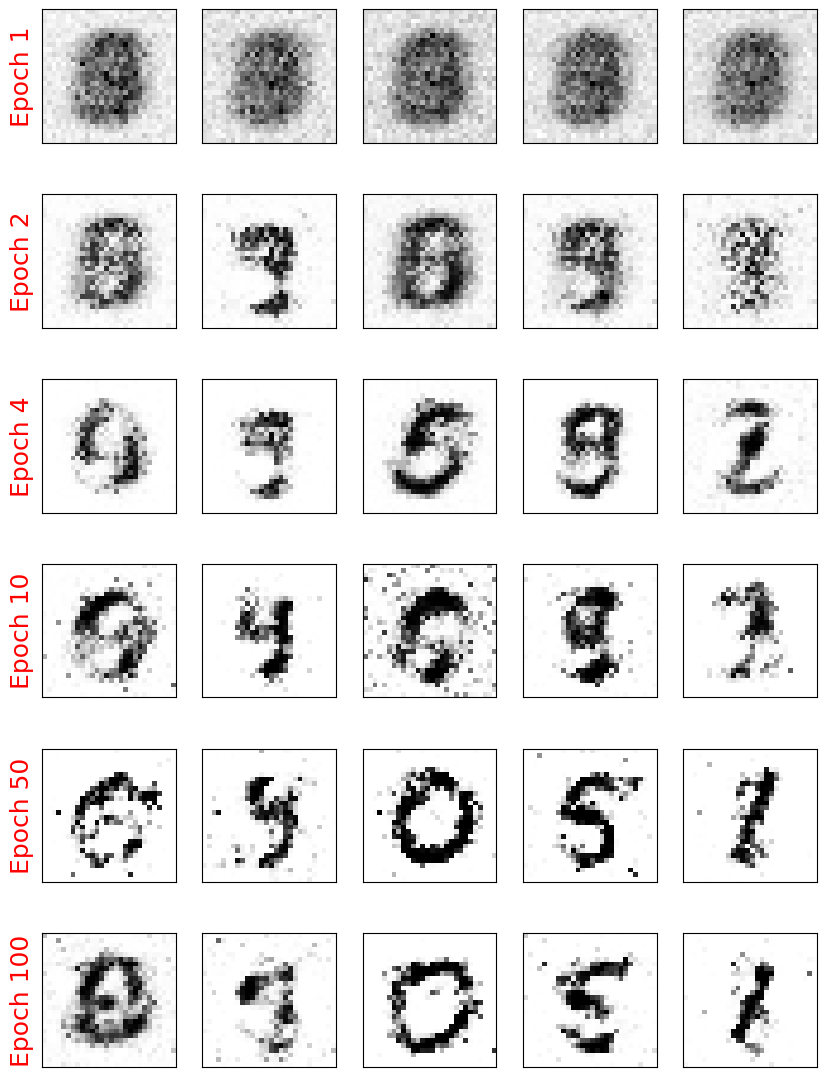

In [15]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e - 1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()

In [16]:
import math


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1).cuda()
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1).cuda()
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) - 2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M

In [17]:
def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    a = Mxx.mean() + Myy.mean() - 2 * Mxy.mean()
    mmd = math.sqrt(max(a, 0))

    return mmd

In [18]:
def compute_score(fake, real, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    print(mmd(Mxx, Mxy, Myy, sigma))

In [19]:
whole_dl = DataLoader(mnist_dataset, batch_size=10000, shuffle=True, drop_last=True)

In [20]:
real_image = next(iter(whole_dl))[0]

In [21]:
compute_score(torch.from_numpy(epoch_samples[-1]), real_image)

0.8995730314479121


In [22]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

batch_size = 64
torch.manual_seed(1)
np.random.seed(1)

mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [23]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model


class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [24]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [25]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [26]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [27]:
def d_train(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [28]:
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [29]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)


def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images + 1) / 2.0


epoch_samples = []
num_epochs = 50
torch.manual_seed(1)

for epoch in range(1, num_epochs + 1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'에포크 {epoch:03d} | 평균 손실 >>'
          f' 생성자/판별자 {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 평균 손실 >> 생성자/판별자 4.8039/0.0996
에포크 002 | 평균 손실 >> 생성자/판별자 4.5641/0.1684
에포크 003 | 평균 손실 >> 생성자/판별자 3.7653/0.2626
에포크 004 | 평균 손실 >> 생성자/판별자 3.0303/0.3347
에포크 005 | 평균 손실 >> 생성자/판별자 2.9178/0.3733
에포크 006 | 평균 손실 >> 생성자/판별자 2.8911/0.3477
에포크 007 | 평균 손실 >> 생성자/판별자 2.8739/0.3449
에포크 008 | 평균 손실 >> 생성자/판별자 2.8455/0.3525
에포크 009 | 평균 손실 >> 생성자/판별자 2.9039/0.3391
에포크 010 | 평균 손실 >> 생성자/판별자 2.9574/0.3188
에포크 011 | 평균 손실 >> 생성자/판별자 2.9617/0.3249
에포크 012 | 평균 손실 >> 생성자/판별자 2.9470/0.3078
에포크 013 | 평균 손실 >> 생성자/판별자 3.0606/0.2831
에포크 014 | 평균 손실 >> 생성자/판별자 3.0804/0.2809
에포크 015 | 평균 손실 >> 생성자/판별자 3.1671/0.2867
에포크 016 | 평균 손실 >> 생성자/판별자 3.2034/0.2619
에포크 017 | 평균 손실 >> 생성자/판별자 3.2618/0.2480
에포크 018 | 평균 손실 >> 생성자/판별자 3.2325/0.2696
에포크 019 | 평균 손실 >> 생성자/판별자 3.3653/0.2436
에포크 020 | 평균 손실 >> 생성자/판별자 3.2794/0.2799
에포크 021 | 평균 손실 >> 생성자/판별자 3.3425/0.2583
에포크 022 | 평균 손실 >> 생성자/판별자 3.4285/0.2338
에포크 023 | 평균 손실 >> 생성자/판별자 3.3747/0.2603
에포크 024 | 평균 손실 >> 생성자/판별자 3.5286/0.2160
에포크 025 | 평균 손실 

IndexError: list index out of range

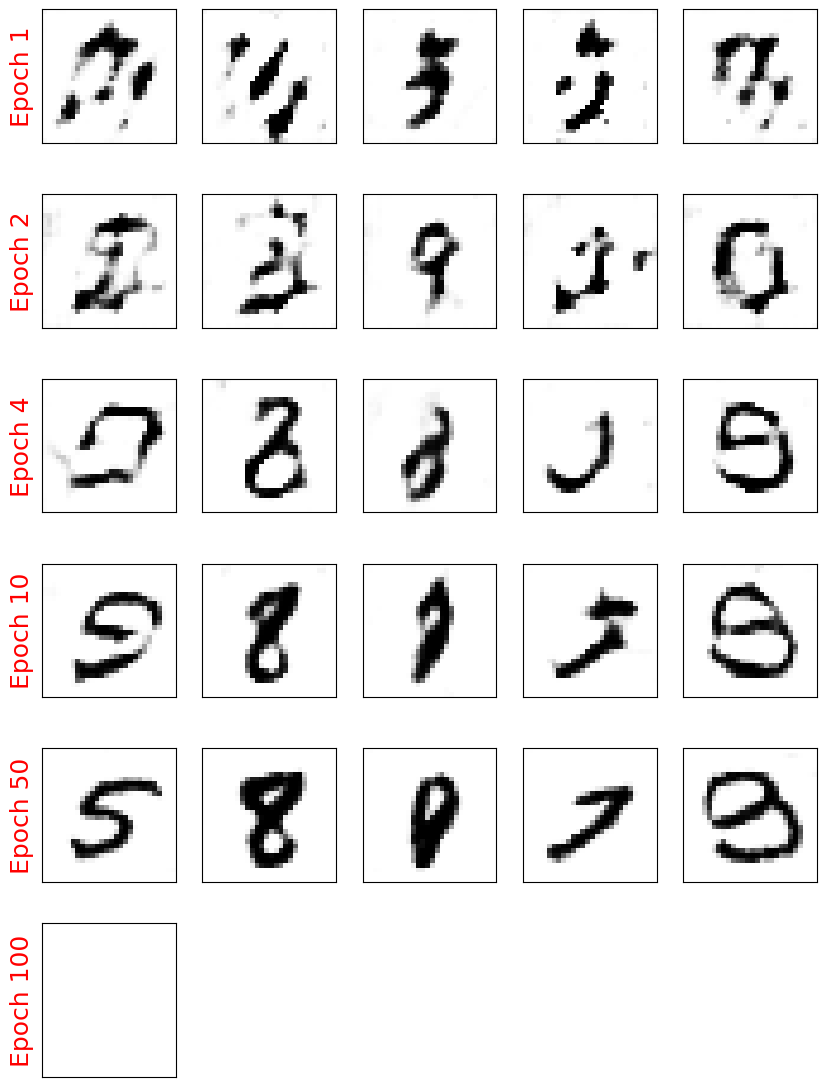

In [30]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e - 1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()

In [31]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters * 4, 4, 1, 0, bias=False),
        nn.InstanceNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model


class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [32]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [33]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    proba_interpolated = disc_model(interpolated)

    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1) ** 2).mean()

In [34]:
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()

In [35]:
def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [36]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 50
torch.manual_seed(1)
critic_iterations = 5

for epoch in range(1, num_epochs + 1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'에포크 {epoch:03d} | 판별자 손실 >>' f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 판별자 손실 >> -0.3014
에포크 002 | 판별자 손실 >> -0.5237
에포크 003 | 판별자 손실 >> -0.5944
에포크 004 | 판별자 손실 >> -0.6254
에포크 005 | 판별자 손실 >> -0.6512
에포크 006 | 판별자 손실 >> -0.6473
에포크 007 | 판별자 손실 >> -0.5878
에포크 008 | 판별자 손실 >> -0.5606
에포크 009 | 판별자 손실 >> -0.5420
에포크 010 | 판별자 손실 >> -0.5245
에포크 011 | 판별자 손실 >> -0.5118
에포크 012 | 판별자 손실 >> -0.5059
에포크 013 | 판별자 손실 >> -0.4941
에포크 014 | 판별자 손실 >> -0.4846
에포크 015 | 판별자 손실 >> -0.4793
에포크 016 | 판별자 손실 >> -0.4697
에포크 017 | 판별자 손실 >> -0.4690
에포크 018 | 판별자 손실 >> -0.4699
에포크 019 | 판별자 손실 >> -0.4691
에포크 020 | 판별자 손실 >> -0.4691
에포크 021 | 판별자 손실 >> -0.4573
에포크 022 | 판별자 손실 >> -0.4624
에포크 023 | 판별자 손실 >> -0.4616
에포크 024 | 판별자 손실 >> -0.4629
에포크 025 | 판별자 손실 >> -0.4591
에포크 026 | 판별자 손실 >> -0.4641
에포크 027 | 판별자 손실 >> -0.4638
에포크 028 | 판별자 손실 >> -0.4693
에포크 029 | 판별자 손실 >> -0.4639
에포크 030 | 판별자 손실 >> -0.4635
에포크 031 | 판별자 손실 >> -0.4693
에포크 032 | 판별자 손실 >> -0.4651
에포크 033 | 판별자 손실 >> -0.4670
에포크 034 | 판별자 손실 >> -0.4662
에포크 035 | 판별자 손실 >> -0.4634
에포크 036 | 판별자 손실 >> 

IndexError: list index out of range

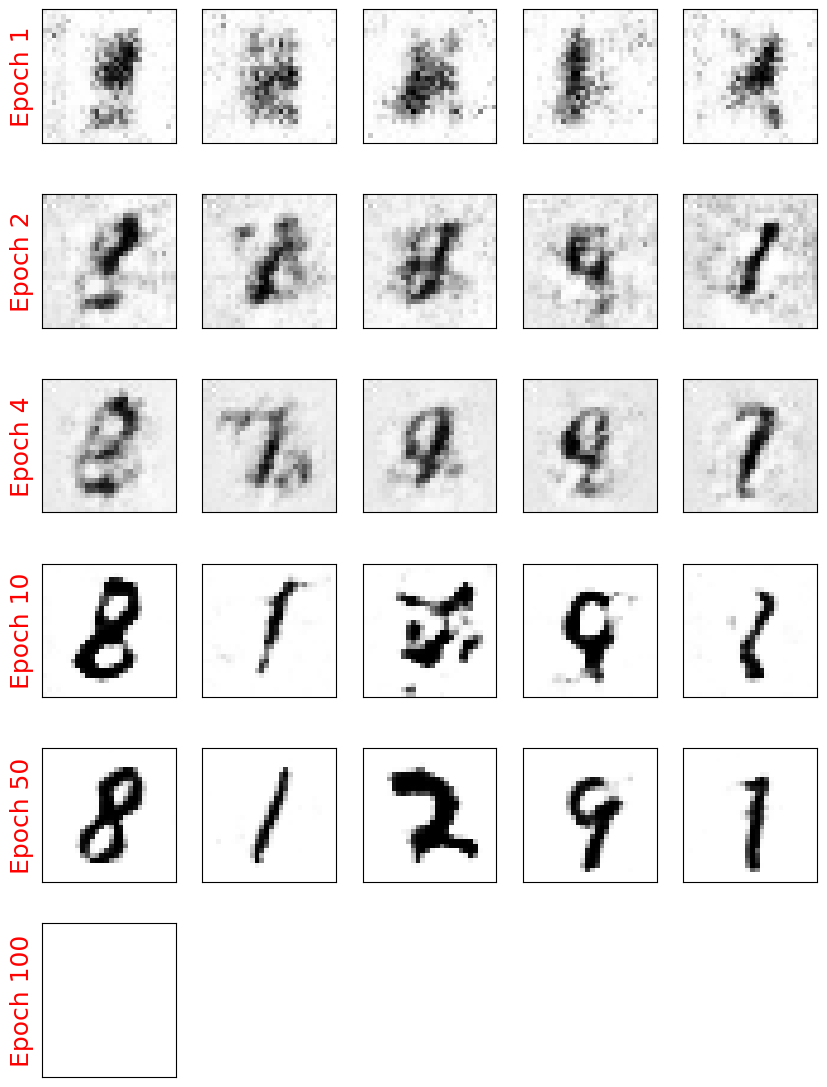

In [37]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples_wgan[e - 1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()